<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">22.418 · Aprenentatge automàtic</p>
<p style="margin: 0; text-align:right;">Grau en Ciència de Dades Aplicada</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Analysis of the KNNBasic algorithm

In this notebook, we will run a basic neighborhood algorithm on the movielens dataset, dump the results, and use pandas to make some data analysis.

In [1]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 7.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618252 sha256=d61c524388c348a58638c330cf14948c347914f8d310c04e6b6a660d45abafad
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
from __future__ import (absolute_import, division, print_function,             
                        unicode_literals)                                      
import pickle
import os

import pandas as pd

from surprise import KNNBasic
from surprise import Dataset                                                     
from surprise import Reader                                                      
from surprise.model_selection import PredefinedKFold
from surprise import dump
from surprise.accuracy import rmse

In [3]:
# We will train and test on the u1.base and u1.test files of the movielens-100k dataset.
# if you haven't already, you need to download the movielens-100k dataset
# You can do it manually, or by running:
Dataset.load_builtin('ml-100k')

# Now, let's load the dataset
train_file = os.path.expanduser('~') + '/.surprise_data/ml-100k/ml-100k/u1.base'
test_file = os.path.expanduser('~') + '/.surprise_data/ml-100k/ml-100k/u1.test'
data = Dataset.load_from_folds([(train_file, test_file)], Reader('ml-100k'))

pkf = PredefinedKFold()

# We'll use a basic nearest neighbor approach, where similarities are computed
# between users.
algo = KNNBasic()                                                       

for trainset, testset in pkf.split(data):
    algo.fit(trainset)                             
    predictions = algo.test(testset)
    rmse(predictions)
                                                                               
    dump.dump('./dump_file', predictions, algo)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9889


In [4]:
# The dump has been saved and we can now use it whenever we want.
# Let's load it and see what we can do
predictions, algo = dump.load('./dump_file')

In [5]:
trainset = algo.trainset
print('algo: {0}, k = {1}, min_k = {2}'.format(algo.__class__.__name__, algo.k, algo.min_k))

algo: KNNBasic, k = 40, min_k = 1


In [6]:
# Let's build a pandas dataframe with all the predictions

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [7]:
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,1,6,5.0,3.468613,"{'actual_k': 20, 'was_impossible': False}",135,20,1.531387
1,1,10,3.0,3.866290,"{'actual_k': 40, 'was_impossible': False}",135,73,0.866290
2,1,12,5.0,4.538194,"{'actual_k': 40, 'was_impossible': False}",135,211,0.461806
3,1,14,5.0,4.235741,"{'actual_k': 40, 'was_impossible': False}",135,140,0.764259
4,1,17,3.0,3.228002,"{'actual_k': 40, 'was_impossible': False}",135,72,0.228002


In [8]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [9]:
# Let's take a look at the best predictions of the algorithm
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
272,5,439,1.0,1.0,"{'actual_k': 3, 'was_impossible': False}",91,3,0.0
886,13,314,1.0,1.0,"{'actual_k': 2, 'was_impossible': False}",373,2,0.0
156,2,314,1.0,1.0,"{'actual_k': 2, 'was_impossible': False}",40,2,0.0
926,13,437,1.0,1.0,"{'actual_k': 3, 'was_impossible': False}",373,3,0.0
9276,206,314,1.0,1.0,"{'actual_k': 1, 'was_impossible': False}",33,2,0.0
19118,405,437,1.0,1.0,"{'actual_k': 3, 'was_impossible': False}",582,3,0.0
8032,181,1334,1.0,1.0,"{'actual_k': 1, 'was_impossible': False}",218,1,0.0
8041,181,1354,1.0,1.0,"{'actual_k': 1, 'was_impossible': False}",218,1,0.0
9202,201,1424,3.0,3.0,"{'actual_k': 1, 'was_impossible': False}",215,1,0.0
3018,60,1123,4.0,4.0,"{'actual_k': 1, 'was_impossible': False}",119,1,0.0


It's interesting to note that these perfect predictions are actually lucky shots: $|U_i|$ is always very small, meaning that very few users have rated the target item. This implies that the set of neighbors is very small (see the ``actual_k`` field)... And, it just happens that all the ratings from the neighbors are the same (and mostly, are equal to that of the target user).

This may be a bit surprising but these lucky shots are actually very important to the accuracy of the algorithm... Try running the same algorithm with a value of ``min_k`` equal to $10$. This means that if there are less than $10$ neighbors, the prediction is set to the mean of all ratings. You'll see your accuracy decrease!

In [10]:
# Now, let's look at the prediction with the biggest error
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
9406,208,302,1.0,4.308447,"{'actual_k': 40, 'was_impossible': False}",11,245,3.308447
19089,405,169,1.0,4.364728,"{'actual_k': 40, 'was_impossible': False}",582,97,3.364728
19785,436,132,1.0,4.365369,"{'actual_k': 40, 'was_impossible': False}",126,200,3.365369
157,2,315,1.0,4.381308,"{'actual_k': 40, 'was_impossible': False}",40,136,3.381308
8503,193,56,1.0,4.386478,"{'actual_k': 40, 'was_impossible': False}",61,312,3.386478
5531,113,976,5.0,1.610771,"{'actual_k': 7, 'was_impossible': False}",31,7,3.389229
7917,181,408,1.0,4.421499,"{'actual_k': 40, 'was_impossible': False}",218,93,3.421499
7390,167,169,1.0,4.664991,"{'actual_k': 40, 'was_impossible': False}",38,97,3.664991
7412,167,1306,5.0,1.000000,"{'actual_k': 1, 'was_impossible': False}",38,1,4.000000
5553,114,1104,5.0,1.000000,"{'actual_k': 1, 'was_impossible': False}",27,1,4.000000


Let's focus first on the last two predictions. Well, we can't do much about them. We should have predicted $5$, but the only available neighbor had a rating of $1$, so we were screwed. The only way to avoid this kind of errors would be to increase the ``min_k`` parameter, but it would actually worsen the accuracy (see note above).

How about the other ones? It seems that for each prediction, the users are some kind of outsiders: they rated their item with a rating of $1$ when the most of the ratings for the item where high (or inversely, rated a *bad* item with a rating of $5$). See the plot below as an illustration for the first rating.

These are situations where baseline estimates would be quite helpful, in order to deal with highly biased users (and items).

Text(0.5, 1.0, 'Number of users having rated item 302')

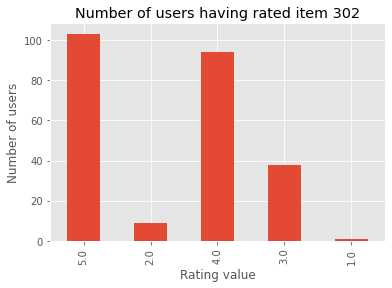

In [11]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
matplotlib.style.use('ggplot')

counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('302')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item 302')